# A simple DNN example using PyTorch

This note describs a simplified DNN procedure in practical data analysis. In general there are two mostly-used machine learning frames: tensorflow and pytorch. These two tools share similar user's interface and pytorch will be introduced particularly. 
A complete DNN model usually contains one input layer, one output layer and several hiden layers. Such model reads arrays of size [nbatch, nfeature] and output arrays of size [nbatch, ndim_out], where "nbatch" denotes the number of events used in each training/test, "nfeature" denotes the number of signatures/properties of each event inputed to the model, and ndim_out is the dimension of expected output, hence 1 for regression problem and 2/3/n for classification problem. To build a NN procedure, the first step is to prepare the training and test datasets from ".root" files.

## Preparing the training and test datasets

In [84]:
import ROOT
from ROOT import TFile, TTree, TH1, TObject, TCanvas, gROOT, TH1D, TColor, TEnv, TGraph
import io
import os
from os import system
import numpy as np
import sys
import array
from array import array
vars_dnn = [
    "lep1_pt","lep1_eta","lep1_phi","lep1_m",
    "lep2_pt","lep2_eta","lep2_phi","lep2_m",
    "jet1_pt","jet1_eta","jet1_phi","jet1_m",
    "jet2_pt","jet2_eta","jet2_phi","jet2_m",
    "jet3_pt","jet3_eta","jet3_phi","jet3_m", 
    "met","met_phi",
    "mtt_truth","mtt_reco"
]

Import tools and set the kinematics used in DNN. "mtt_truth" and "mtt_reco" are labels. The others are features.

In [85]:
def root_to_np_dnn(_file, _tree, _vars):
  print("loading DNN branches\n")
  f = TFile.Open(_file)
  tree = getattr(f,_tree)
  N_evts = tree.GetEntries()
  data_np = np.zeros((N_evts, len(_vars)))

  for n, event in enumerate(tree):
    if(n%100000 == 0) : print('Loading DNN:  {:n}/{:n}'.format(n, N_evts))
    for i, key in enumerate(_vars) :
      try:
        fresh = getattr(event, key)
      except:
        fresh = None
      data_np[n][i] = fresh

  return data_np

Read the branches in root file, then store it as "numpy" of size [N_entry, N_var]. Numpy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.

In [86]:
def split_and_save(_input, _tree,   save_path= "./", pfx = "" , train_frac = 0.8):
    system('mkdir -p  '+ save_path+'/'+pfx)
    print('using working dir: ' + save_path+'/'+pfx )
    
    np_dnn = root_to_np_dnn(_input, _tree, vars_dnn)
    
    #shuffle the array and split it into two sets [train_frac, 1-train_frac]
    np.random.shuffle(np_dnn)
    ntrain =int(np_dnn.shape[0] * train_frac)
    np_train = np_dnn[0:ntrain]
    np_test = np_dnn[ntrain:-1]

    #label1 "truth_mtt" and label2 "reco_mtt" are splitted from the latest two columns [-2, -1]
    (np_dnn_feature, np_dnn_label1, np_dnn_label2) = np.hsplit(np_dnn, [-2,-1])
    (np_train_feature, np_train_label1, np_train_label2) = np.hsplit(np_train, [-2,-1])
    (np_test_feature, np_test_label1, np_test_label2) = np.hsplit(np_test, [-2,-1])

    #print(np_dnn_feature)
    #print(np_dnn_label1)
    #print(np_dnn_label2)
    
    #save all arrays as ".npy"
    with io.open(save_path+'/'+pfx+'/full_feature.npy', 'wb') as f:
        np.save(f,np_dnn_feature)
    with io.open(save_path+'/'+pfx+'/train_feature.npy', 'wb') as f:
        np.save(f,np_train_feature)
    with io.open(save_path+'/'+pfx+'/test_feature.npy', 'wb') as f:
        np.save(f,np_test_feature)

    with io.open(save_path+'/'+pfx+'/full_label1.npy', 'wb') as f:
        np.save(f,np_dnn_label1)
    with io.open(save_path+'/'+pfx+'/train_label1.npy', 'wb') as f:
        np.save(f,np_train_label1)
    with io.open(save_path+'/'+pfx+'/test_label1.npy', 'wb') as f:
        np.save(f,np_test_label1)

    with io.open(save_path+'/'+pfx+'/full_label2.npy', 'wb') as f:
        np.save(f,np_dnn_label2)
    with io.open(save_path+'/'+pfx+'/train_label2.npy', 'wb') as f:
        np.save(f,np_train_label2)
    with io.open(save_path+'/'+pfx+'/test_label2.npy', 'wb') as f:
        np.save(f,np_test_label2)

    return

Read the output numpy of "root_to_np_dnn", then split into training set and test set accoring to the given fraction.

In [87]:
tree_name = "tree"
kp = "./input/"
signal = kp +"SM_ttbar.root"
test1 = kp +"Zp1TeV_ttbar.root"
test2 = kp +"Zp2TeV_ttbar.root"
# signal is the SM ttbar decay, used in training. the other two are BSM, only for test, with train_frac = 0
split_and_save(signal, tree_name, './npys', 'signal', 0.8)
split_and_save(test1, tree_name, './npys', 'test1', 0.)
split_and_save(test2, tree_name, './npys', 'test2', 0.)

using working dir: ./npys/signal
loading DNN branches

Loading DNN:  0/62710
using working dir: ./npys/test1
loading DNN branches

Loading DNN:  0/24634
using working dir: ./npys/test2
loading DNN branches

Loading DNN:  0/18395


Then we have the ".npy" inputs ready for training. 

## Build DNN model and Training

In [88]:
import torch
from torch import nn, optim
sys.path.append("..")
torch.manual_seed(42)
torch.autograd.set_detect_anomaly(True)
torch.set_default_tensor_type(torch.DoubleTensor)
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu') # the cuda is the Nvidia interface for GPU training

In [89]:
class DNNModel(nn.Module):
    def __init__(self, N_dnn_var, N_dimout = 1):
      super(DNNModel, self).__init__()
      self.N_dnn_var = N_dnn_var
      self.N_dimout = N_dimout
      self.dnn = nn.Sequential(
        nn.Linear(self.N_dnn_var, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, self.N_dimout),
        )
#define how the model proceeds when calling
    def forward(self, inputsDNN):
      output = self.dnn(inputsDNN)
      return output

"nn" is the Base class for all neural network modules in pytorch. Your models should also subclass this class. Modules can also contain other Modules, allowing to nest them in a tree structure. You can assign the submodules as regular attributes. Submodules assigned in this way will be registered.
Here the model is simplied. "N_dnn_var" is the number of features in training. nn.Sequential help to define a sequence of nn layers:

    1. nn.Linear(self.N_dnn_var, 100)： first fullly-connected layer connecting the input layer and hidden layer1 with 100 nodes. 
    2. nn.Linear(100, 100) x 2: connect the [hidden layer1, hidden layer2]. and [hidden layer2, hidden layer3]
    3. nn.Linear(100, 1): regression layer between the hidden layer 3 and 1-dim output.
    
nn.ReLU() is the activation function，defines the output of that node given an input or set of inputs. ReLU(x) = max(x, 0).

Then we can start training!

In [90]:
def train():
    # inputs prepared before
    path = ("./npys/signal/")
    train_feature = torch.from_numpy(np.load(path+"train_feature.npy"))
    train_label = torch.from_numpy(np.load(path+"train_label1.npy"))
    test_feature = torch.from_numpy(np.load(path+"test_feature.npy"))
    test_label = torch.from_numpy(np.load(path+"test_label1.npy"))

    model = DNNModel(train_feature.shape[1],1).to(device)
    
    #loss function in training, L1Loss means MAE (mean absolute error)
    loss = nn.L1Loss().to(device)
    
    #optimizer is the tool helping to optimize the paramters according to Loss function 
    #lr means "learing rate", the speed at which a machine learning model "learns"
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    os.system('mkdir -p ./models/')
    os.system('mkdir -p ./loss/')
    
    floss = open("./loss/loss.txt", "w+")

    num_epochs = 51
  
    for epoch in range(num_epochs):
      #set the model to train mode
      model.train()
      train_out = model(train_feature.to(device))
      L = loss( train_out.to(device), train_label.to(device))
      
      # clear the gradient, backward the loss function and optimize the paramters
      optimizer.zero_grad()
      L.backward()
      optimizer.step()
    
      #set the model to evaluation mode
      # measure the loss of test set
      model.eval()
      with torch.no_grad():
        test_out = model(test_feature.to(device))
      L_test = loss(test_out.to(device),  test_label.to(device))
    
      floss.write("+Epoch:  {:n}\n".format(epoch))
      floss.write("+train_loss:  {:f}\n".format(L.item()))
      floss.write("+test_loss:  {:f}\n\n".format(L_test.item()))

      print('epoch: {:d}      |     train_loss: {:6.4f}      |    test_loss: {:6.4f} '.format(epoch,  L.item(), L_test.item()))
      if(epoch%10 == 0 ): torch.save(model.state_dict(), './models/epoch_{:d}.pkl'.format(epoch))

    floss.close()

This the main function for training, using the two most important tools "Loss" and "Optimizer" of pytorch to measure the Loss function, perform back-ward propagation and optimize all paramters in the model. 

In [91]:
train()

epoch: 0      |     train_loss: 551.1341      |    test_loss: 547.9028 
epoch: 1      |     train_loss: 549.0781      |    test_loss: 545.9478 
epoch: 2      |     train_loss: 547.1155      |    test_loss: 544.0599 
epoch: 3      |     train_loss: 545.2200      |    test_loss: 542.1061 
epoch: 4      |     train_loss: 543.2589      |    test_loss: 540.0044 
epoch: 5      |     train_loss: 541.1493      |    test_loss: 537.7078 
epoch: 6      |     train_loss: 538.8435      |    test_loss: 535.1854 
epoch: 7      |     train_loss: 536.3100      |    test_loss: 532.3935 
epoch: 8      |     train_loss: 533.5064      |    test_loss: 529.2885 
epoch: 9      |     train_loss: 530.3891      |    test_loss: 525.8437 
epoch: 10      |     train_loss: 526.9306      |    test_loss: 522.0091 
epoch: 11      |     train_loss: 523.0804      |    test_loss: 517.6795 
epoch: 12      |     train_loss: 518.7325      |    test_loss: 512.7485 
epoch: 13      |     train_loss: 513.7815      |    test_loss

The train loop over all events for 50 times, recorded as 50 epoches. In experiments, one epoch may contain millions of events which can't be handled by CPU/GPU, thereby one epoch is divided into some batches. The loos decays sharply at a high learning rate, but the high lr could also lead to easy over training. And the adjustment of lr, as well as other "hyperparameters" is the key to a decent NN model. 

The Loss function can also be plotted:

In [92]:
gROOT.SetStyle("ATLAS")

env = TEnv()
env.ReadFile("./loss/loss.txt", ROOT.EEnvLevel(0))
ltrain = env.GetValue("train_loss", "0.")
ltest = env.GetValue("test_loss", "0.")
train = ltrain.split(" ")
test = ltest.split(" ")
n_epoch = len(test)

x_train = np.zeros(n_epoch)
x_test = np.zeros(n_epoch)
y_train = np.zeros(n_epoch)
y_test = np.zeros(n_epoch)

for i in range(n_epoch):
  x_train[i] = i+1
  y_train[i] = float(train[i])

  x_test[i] = i+ 1.
  y_test[i] = float(test[i])

g1 = TGraph(n_epoch, x_train, y_train)
g2 = TGraph(n_epoch, x_test, y_test)

g1.SetMarkerColor(2)
g1.SetLineColor(2)
g1.SetMarkerSize(0.2)
g2.SetMarkerColor(4)
g2.SetMarkerSize(0.2)
g2.SetLineColor(4)

mg = ROOT.TMultiGraph()
mg.Add(g1)
mg.Add(g2)
myc = TCanvas("c", "test")
myc.SetLeftMargin(0.15)
myc.SetBottomMargin(0.2)
h1 =ROOT.TH2F("h1", "zoom", 10, -1., n_epoch+10, 10, 0.3, 0.8)

h1.GetYaxis().SetLimits(100, 600)
h1.GetXaxis().SetTitle("Epoch")
h1.GetYaxis().SetTitle("Loss")
h1.GetYaxis().SetNdivisions(505)
h1.Draw()

mg.Draw("PC")
leg = ROOT.TLegend(0.65, 0.65, 0.85, 0.85)
leg.SetBorderSize(0)
leg.AddEntry(g1, "Train", "L" )
leg.AddEntry(g2, "Test", "L" )
leg.Draw("same")

myc.Modified()
myc.Update()

myc.SaveAs("loss.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file loss.png has been created


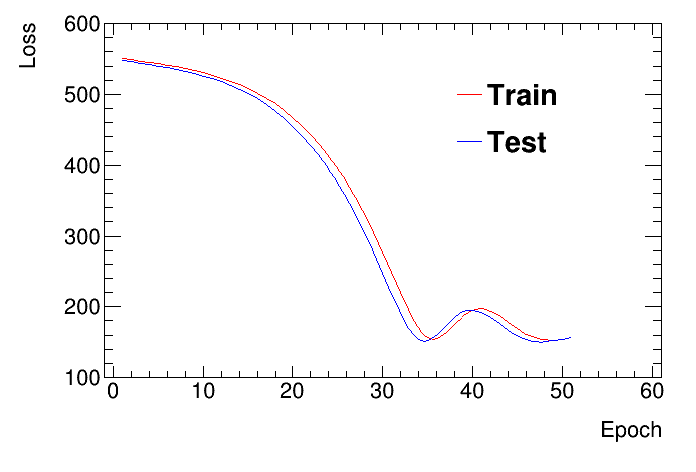

In [93]:
from IPython.display import Image 
Image(filename='loss.png') 

The trained model is now saved. One can easily re-access it with:

In [94]:
def modelload(model, path):
    model.load_state_dict(torch.load(path))

## Test / Application of the DNN model 

The trained DNN model can be then used to perform various of tests. In principle you can apply the model to all kinds of datasets except the training set itself. We train the ttbar regreesion model using standard model input. Here we'll test it using SM ttbar and BDM ttar from Z', produced at mZ' = 1 TeV and 2 TeV. 

The new inputs are read from numpy, while the output can be ether numpy or root. Considering the output is usually decorated as a new branch of input tree, we will have the output stored in root file, including three branches "DNN_output", "mtt_reco" and "mtt_truth", denoting the mtt from DNN, mtt from event reconstruction and the ture mtt respectively.  

In [95]:
def WTR(_outdir, _file, model, dnn_in, dnn_label, dnn_reco):
  _out = _outdir + _file
  model.eval()
  with torch.no_grad():
    dnn_out = model(dnn_in)

  f = TFile.Open(_out, "RECREATE")
  t = ROOT.TTree("DNN", "DNN")
  _val1 = array('f', [0.])
  _val2 = array('f', [0.])
  _val3 = array('f', [0.])
  branch1 = t.Branch("DNN_output",  _val1, "newbranch1")
  branch2 = t.Branch("mtt_truth",  _val2, "newbranch2")
  branch3 = t.Branch("mtt_reco",  _val3, "newbranch3")
  Nevts = dnn_out.shape[0]
  for n in range(Nevts):
    _val1[0] = dnn_out[n]
    _val2[0] = dnn_label[n]
    _val3[0] = dnn_reco[n]
    t.Fill()
  t.Write("", TObject.kOverwrite)
  f.Write()
  f.Close()

In [96]:
testmodel = DNNModel(22, 1)
modelload(testmodel, './models/epoch_500.pkl')

_outdir = './output/'
os.system('mkdir -p '+_outdir)

path = ("./npys/signal/")
SM_feature = torch.from_numpy(np.load(path+"test_feature.npy"))
SM_label = torch.from_numpy(np.load(path+"test_label1.npy"))
SM_label2 = torch.from_numpy(np.load(path+"test_label2.npy"))
path = ("./npys/test1/")
Z1_feature = torch.from_numpy(np.load(path+"test_feature.npy"))
Z1_label = torch.from_numpy(np.load(path+"test_label1.npy"))
Z1_label2 = torch.from_numpy(np.load(path+"test_label2.npy"))
path = ("./npys/test2/")
Z2_feature = torch.from_numpy(np.load(path+"test_feature.npy"))
Z2_label = torch.from_numpy(np.load(path+"test_label1.npy"))
Z2_label2 = torch.from_numpy(np.load(path+"test_label2.npy"))

WTR(_outdir,"SM.root", testmodel, SM_feature, SM_label, SM_label2)
WTR(_outdir,"Z1.root", testmodel, Z1_feature, Z1_label, Z1_label2)
WTR(_outdir,"Z2.root", testmodel, Z2_feature, Z2_label, Z2_label2)


Then the DNN procedure is done! One can try some plotings. In example, to check the performance of DNN and even-reco mtt. 

In [97]:

myc = TCanvas("c", "test", 200, 10, 700, 700)
myc.SetLeftMargin(0.15)
myc.SetBottomMargin(0.2)
gROOT.SetStyle("ATLAS")

f1 = TFile.Open("./output/SM.root")
f2 = TFile.Open("./output/Z1.root")
f3 = TFile.Open("./output/Z2.root")

t1 = f1.DNN
t2 = f2.DNN
t3 = f3.DNN

h11 = TH1D("h11", "h11", 50, 0, 2500)
h12 = TH1D("h12", "h12", 50, 0, 2500)
h21 = TH1D("h21", "h21", 50, 0, 2500)
h22 = TH1D("h22", "h22", 50, 0, 2500)
h31 = TH1D("h31", "h31", 50, 0, 2500)
h32 = TH1D("h32", "h32", 50, 0, 2500)

def btoh(t, h, var):
  for evt in t :
    k = getattr(evt, var)
    h.Fill(k)
  h.Scale(1./h.Integral())
  return

btoh(t1, h11, "DNN_output")
btoh(t1, h12, "mtt_truth")
btoh(t2, h21, "DNN_output")
btoh(t2, h22, "mtt_truth")
btoh(t3, h31, "DNN_output")
btoh(t3, h32, "mtt_truth")

h11.SetLineColor(ROOT.kRed)
h12.SetLineColor(ROOT.kRed)
h21.SetLineColor(ROOT.kBlue)
h22.SetLineColor(ROOT.kBlue)
h31.SetLineColor(ROOT.kGreen)
h32.SetLineColor(ROOT.kGreen)

h31.SetAxisRange(0.,0.5,"Y")
h31.GetXaxis().SetTitle("mtt[MeV]")
h31.GetYaxis().SetTitle("Normalisation")
h31.GetYaxis().SetNdivisions(505)

h12.SetLineStyle(9)
h22.SetLineStyle(9)
h32.SetLineStyle(9)

h31.Draw("HIST")
h32.Draw("HISTsame")
h21.Draw("HISTsame")
h22.Draw("HISTsame")
h11.Draw("HISTsame")
h12.Draw("HISTsame")

leg = ROOT.TLegend(0.6, 0.6, 0.85, 0.85)
leg.SetBorderSize(0)
leg.AddEntry(h11, "DNN SM t#bar{t}", "f" )
leg.AddEntry(h21, "DNN Z' #rightarrow t#bar{t} 1 TeV", "f" )
leg.AddEntry(h31, "DNN Z' #rightarrow t#bar{t} 2 TeV", "f" )
leg.AddEntry(h12, "True SM t#bar{t}", "f" )
leg.AddEntry(h22, "True Z' #rightarrow t#bar{t} 1 TeV", "f" )
leg.AddEntry(h32, "True Z' #rightarrow t#bar{t} 2 TeV", "f" )
leg.Draw("same")

myc.SaveAs("DNN_Mass.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file DNN_Mass.png has been created


In [98]:
myc = TCanvas("c", "test", 200, 10, 700, 700)
myc.SetLeftMargin(0.15)
myc.SetBottomMargin(0.2)
gROOT.SetStyle("ATLAS")

f1 = TFile.Open("./output/SM.root")
f2 = TFile.Open("./output/Z1.root")
f3 = TFile.Open("./output/Z2.root")

t1 = f1.DNN
t2 = f2.DNN
t3 = f3.DNN

h11 = TH1D("h11", "h11", 50, 0, 2500)
h12 = TH1D("h12", "h12", 50, 0, 2500)
h21 = TH1D("h21", "h21", 50, 0, 2500)
h22 = TH1D("h22", "h22", 50, 0, 2500)
h31 = TH1D("h31", "h31", 50, 0, 2500)
h32 = TH1D("h32", "h32", 50, 0, 2500)

def btoh(t, h, var):
  for evt in t :
    k = getattr(evt, var)
    h.Fill(k)
  h.Scale(1./h.Integral())
  return

btoh(t1, h11, "mtt_reco")
btoh(t1, h12, "mtt_truth")
btoh(t2, h21, "mtt_reco")
btoh(t2, h22, "mtt_truth")
btoh(t3, h31, "mtt_reco")
btoh(t3, h32, "mtt_truth")

h11.SetLineColor(ROOT.kRed)
h12.SetLineColor(ROOT.kRed)
h21.SetLineColor(ROOT.kBlue)

h22.SetLineColor(ROOT.kBlue)
h31.SetLineColor(ROOT.kGreen)
h32.SetLineColor(ROOT.kGreen)

h31.SetAxisRange(0.,0.5,"Y")
h31.GetXaxis().SetTitle("mtt[MeV]")
h31.GetYaxis().SetTitle("Normalisation")
h31.GetYaxis().SetNdivisions(505)

h12.SetLineStyle(9)
h22.SetLineStyle(9)
h32.SetLineStyle(9)

h31.Draw("HIST")
h32.Draw("HISTsame")
h21.Draw("HISTsame")
h22.Draw("HISTsame")
h11.Draw("HISTsame")
h12.Draw("HISTsame")

leg = ROOT.TLegend(0.6, 0.6, 0.85, 0.85)
leg.SetBorderSize(0)
leg.AddEntry(h11, "Reco SM t#bar{t}", "f" )
leg.AddEntry(h21, "Reco Z' #rightarrow t#bar{t} 1 TeV", "f" )
leg.AddEntry(h31, "Reco Z' #rightarrow t#bar{t} 2 TeV", "f" )
leg.AddEntry(h12, "True SM t#bar{t}", "f" )
leg.AddEntry(h22, "True Z' #rightarrow t#bar{t} 1 TeV", "f" )
leg.AddEntry(h32, "True Z' #rightarrow t#bar{t} 2 TeV", "f" )
leg.Draw("same")

myc.SaveAs("Reco_Mass.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file Reco_Mass.png has been created


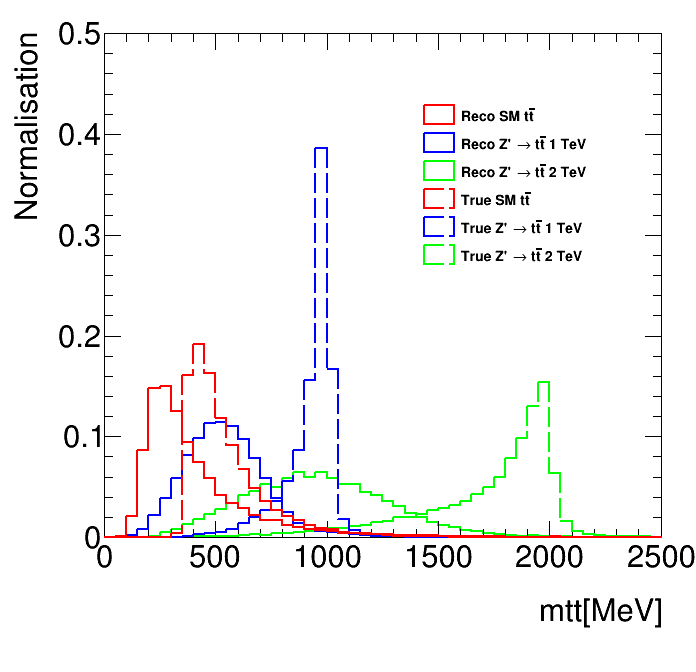

In [99]:
from IPython.display import Image 
Image(filename='Reco_Mass.png') 

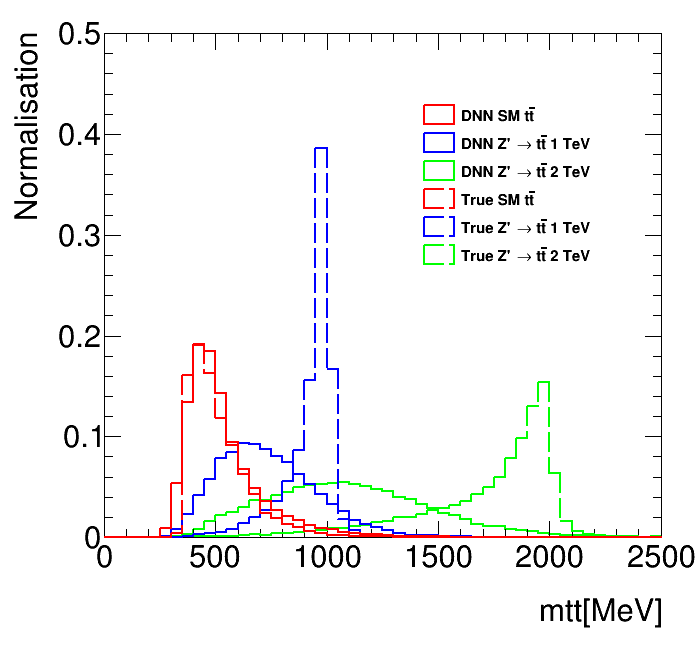

In [100]:
Image(filename='DNN_Mass.png')

The DNN model works significantly superior at low mass. To improve the performance at high mass, a tricky way is to adjust the distribution of mtt in training set. By introducing more high-mass events and wider distribution in training, the model will be more sensitive to the changing of mtt. The adjustment of parameters, even the model itself always provides opportunities. 

## DNN in classification

Classification, particularly signal/background classification is a "classic" usage of NN. The BDT method is relatively more widely used in experiments. However, to dedicate issues, like more-than-2-item classificaiton and complicated non-linear system, the NN is an optional choice. 

We also take the ttbar event as an example. The classification DNN model shares the same structure of the regression DNN. The input features are identical as well, but the classification DNN requires both signal and background events inputed to the training. In addition, the output is the [p1, p2] of event type, i.e. possibility of being background or signal ([1, 0] or [0, 1], dim = 2). 

We consider the SM ttbar as signal while Z' at 1 TeV as background. The new numpy are generated like:

In [101]:
path = ("./npys/")
np_sig_feature = (np.load(path+"signal/train_feature.npy"))[0:20000]
np_bkg_feature = (np.load(path+"test1/test_feature.npy"))[0:20000]
np_sig_label = np.full(np_sig_feature.shape[0], 1)
np_bkg_label = np.full(np_bkg_feature.shape[0], 0)
np_class_input = np.concatenate((np_sig_feature,np_bkg_feature),axis=0)
np_class_label = np.concatenate((np_sig_label,np_bkg_label),axis=0)
class_input = torch.from_numpy(np_class_input)
class_label = torch.from_numpy(np_class_label)

np_sig_feature_test = (np.load(path+"signal/train_feature.npy"))[20000:24000]
np_bkg_feature_test = (np.load(path+"test1/test_feature.npy"))[20000:24000]
np_sig_label_test = np.full(np_sig_feature_test.shape[0], 1)
np_bkg_label_test = np.full(np_bkg_feature_test.shape[0], 0)
np_class_input_test = np.concatenate((np_sig_feature_test,np_bkg_feature_test),axis=0)
np_class_label_test = np.concatenate((np_sig_label_test,np_bkg_label_test),axis=0)
class_input_test = torch.from_numpy(np_class_input_test)
class_label_test = torch.from_numpy(np_class_label_test)

In [103]:
def train_class():
    # inputs prepared before
    # dim out is now set to 2
    model = DNNModel(class_input.shape[1], 2).to(device)
    
    #loss function in training, cross entropy is for classification
    loss = nn.CrossEntropyLoss().to(device)
    
    #optimizer is the tool helping to optimize the paramters according to Loss function 
    #lr means "learing rate", the speed at which a machine learning model "learns"
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    os.system('mkdir -p ./models_class/')
    os.system('mkdir -p ./loss_class/')
    
    floss = open("./loss_class/loss.txt", "w+")

    num_epochs = 51
  
    for epoch in range(num_epochs):
      #set the model to train mode
      model.train()
      train_out = model(class_input.to(device))
      L = loss( train_out.to(device), class_label.to(device))
      
      # clear the gradient, backward the loss function and optimize the paramters
      optimizer.zero_grad()
      L.backward()
      optimizer.step()
    
      #set the model to evaluation mode
      # measure the loss of test set
      model.eval()
      with torch.no_grad():
        test_out = model(class_input_test.to(device))
      L_test = loss(test_out.to(device),  class_label_test.to(device))
    
      floss.write("+Epoch:  {:n}\n".format(epoch))
      floss.write("+train_loss:  {:f}\n".format(L.item()))
      floss.write("+test_loss:  {:f}\n\n".format(L_test.item()))

      print('epoch: {:d}      |     train_loss: {:6.4f}      |    test_loss: {:6.4f} '.format(epoch,  L.item(), L_test.item()))
      if(epoch%10 == 0 ): torch.save(model.state_dict(), './models_class/epoch_{:d}.pkl'.format(epoch))

    floss.close()

In [104]:
train_class()

epoch: 0      |     train_loss: 0.7499      |    test_loss: 1.2574 
epoch: 1      |     train_loss: 1.2462      |    test_loss: 0.7425 
epoch: 2      |     train_loss: 0.7347      |    test_loss: 0.7302 
epoch: 3      |     train_loss: 0.7214      |    test_loss: 0.8714 
epoch: 4      |     train_loss: 0.8600      |    test_loss: 0.8563 
epoch: 5      |     train_loss: 0.8449      |    test_loss: 0.7545 
epoch: 6      |     train_loss: 0.7449      |    test_loss: 0.6666 
epoch: 7      |     train_loss: 0.6588      |    test_loss: 0.6527 
epoch: 8      |     train_loss: 0.6458      |    test_loss: 0.6943 
epoch: 9      |     train_loss: 0.6878      |    test_loss: 0.7227 
epoch: 10      |     train_loss: 0.7167      |    test_loss: 0.7060 
epoch: 11      |     train_loss: 0.7007      |    test_loss: 0.6655 
epoch: 12      |     train_loss: 0.6609      |    test_loss: 0.6353 
epoch: 13      |     train_loss: 0.6312      |    test_loss: 0.6313 
epoch: 14      |     train_loss: 0.6274     

In [106]:
import torch.nn.functional as F

class_model = DNNModel(22, 2)
modelload(class_model, './models_class/epoch_400.pkl')
class_model.eval()
with torch.no_grad():
#    sigout = class_model(torch.from_numpy(np_sig_feature_test))
#    bkgout = class_model(torch.from_numpy(np_bkg_feature_test))

    sigout = (F.softmax(class_model(torch.from_numpy(np_sig_feature_test))))[:,-1]
    bkgout = (F.softmax(class_model(torch.from_numpy(np_bkg_feature_test))))[:,-1]

h1 = TH1D("h1", "h1", 100, 0, 1.00)
h2 = TH1D("h2", "h1", 100, 0, 1.00)
for i in range(sigout.shape[0]):
    h1.Fill(sigout[i])
for i in range(bkgout.shape[0]):
    h2.Fill(bkgout[i])  
h1.Scale(1./h1.Integral())
h2.Scale(1./h2.Integral())

h1.SetLineColor(ROOT.kRed)
h2.SetLineColor(ROOT.kBlue)

h1.SetAxisRange(0.,0.04,"Y")
h1.GetXaxis().SetTitle("DNN score")
h1.GetYaxis().SetTitle("Normalisation")
h1.GetYaxis().SetNdivisions(505)

h1.Draw("HIST")
h2.Draw("HISTsame")

leg = ROOT.TLegend(0.5, 0.6, 0.75, 0.85)
leg.SetBorderSize(0)
leg.AddEntry(h1, "signal", "f" )
leg.AddEntry(h2, "background", "f" )
leg.Draw("same")

myc.SaveAs("softmax.png")


<ipython-input-106-92a4d17e549f>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sigout = (F.softmax(class_model(torch.from_numpy(np_sig_feature_test))))[:,-1]
<ipython-input-106-92a4d17e549f>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  bkgout = (F.softmax(class_model(torch.from_numpy(np_bkg_feature_test))))[:,-1]
Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h2 (Potential memory leak).
Info in <TCanvas::Print>: png file softmax.png has been created


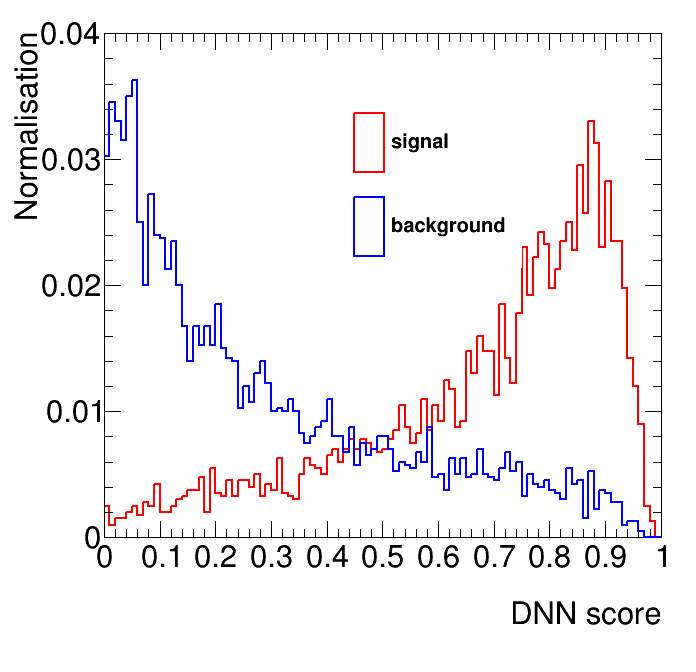

In [107]:
Image(filename='softmax.png')